In [1]:
from comet_ml import Experiment
import numpy as np 
from matplotlib import pyplot as plt
import os 
import time 
import tensorflow as tf 


# #ISIC 2019 25000 IMAGES DATASET LOCATION
# train_path = "/home/mrb685/Datasets/Thesis Final Dataset/train/"
# val_path  = "/home/mrb685/Datasets/Thesis Final Dataset/val/"
# test_path = "/home/mrb685/Datasets/Thesis Final Dataset/test/"

# # U-net cropped dataset 
# train_path = "/home/mrb685/Datasets/BCDU-Segmentations-Cropped/train/"
# val_path  = "/home/mrb685/Datasets/BCDU-Segmentations-Cropped/val/"
# test_path = "/home/mrb685/Datasets/BCDU-Segmentations-Cropped/test/"

# Cropped dataset (Black border removed )
train_path = "/home/mrb685/Datasets/Complete Random Cropped/"
val_path  = "/home/mrb685/Datasets/Resized Cropped Dataset/val/"
test_path = "/home/mrb685/Datasets/Resized Cropped Dataset/test/"

# train_path = "/home/mrb685/Datasets/GAN Balanced/train/"
# val_path  = "/home/mrb685/Datasets/GAN Balanced/test/"

CATEGORIES = ["NV", "MEL"]


# # Retrain vanilla resnet50 with acc metrics
# model_name = "resnet_retrain_acc"

# Retrain no cw 
# model_name = "resnet_retrain_acc_no_cw"

# Transfer learn with acc metrics
# model_name = "resnet_transfer_acc"

# shallow vs deep 
model_name = "all_base_focal"


# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.1)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
# from keras import backend as K
# import tensorflow as tf
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.1
# session = tf.Session(config=config)
# K.set_session(session)

# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)

# sess_cpu = tf.Session(config=tf.ConfigProto(device_count={'GPU': 0}))

# from tensorflow.python.client import device_lib

# def get_available_gpus():
#     local_device_protos = device_lib.list_local_devices()
#     return [x.name for x in local_device_protos if x.device_type == 'GPU']

# print(get_available_gpus())
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
#sess_cpu = tf.Session(config=tf.ConfigProto(device_count={'GPU': 0}))


In [2]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


### CALLBACKS 

# tensorboard callback 
tensorboard_name = f"Multimodal_skin_lesion_{model_name}"
tensorboard =  tf.keras.callbacks.TensorBoard(log_dir=f'logs/{tensorboard_name}')


# model checkpoint callback 
checkpoint_path = f"/home/mrb685/CheckPoints/{model_name}/cp.ckpt" 
checkpoint_dir = os.path.dirname(checkpoint_path)

if not os.path.isdir(checkpoint_dir):
    os.mkdir(checkpoint_dir)

if not os.path.isfile(checkpoint_path):
    open(checkpoint_path, 'w').close()
        


# Create a callback that saves the model's weights
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                                 verbose=1,
                                                 monitor='val_accuracy',
                                                mode='max')

lr_on_plateau_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                  patience=5, min_lr=0.00001)

early_stop_callback = EarlyStopping(monitor='val_accuracy', patience=10)

In [3]:
from keras_preprocessing.image import ImageDataGenerator

In [4]:
import numpy as np
import sklearn.metrics as sklm


class CustomMetricsAndEarlyStop(tf.keras.callbacks.Callback):
    
    def __init__(self, patience=5):
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None
    
    def on_train_begin(self, logs={}):

        
        self.auc = []
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best_auc = 0

    def on_epoch_end(self, epoch, logs={}):
        print(f"Log: {logs}")
        auc = logs["val_auc"]
        self.auc.append(auc)
        current_auc = auc
        
        if np.greater(current_auc, self.best_auc):
            save_path = f"/home/mrb685/Saved Models/{model_name}_auc.h5"
            print(f"val_auc improved from {self.best_auc} to {current_auc}. Saving model!")
            self.model.save(save_path)
            self.best_auc = current_auc
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
                
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print('Restoring model weights from the end of the best epoch.')
                self.model.set_weights(self.best_weights)
        
    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print('Epoch %05d: early stopping' % (self.stopped_epoch + 1))

In [ ]:
import threading
class threadsafe_iter:
    """Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self): # Py3
        with self.lock:
            return next(self.it)


def threadsafe_generator(f):
    """A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g

def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]

@threadsafe_generator
def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

In [ ]:
X, y = next(train_generator)
for x in range(10):
    print(X[x].shape)
    plt.imshow(X[x])
    plt.show()

In [5]:
train_generator = datagen.flow_from_directory(
        target_size=(IMG_SIZE, IMG_SIZE),
        directory=train_path,
        batch_size=BATCH_SIZE, 
        shuffle = True,
        classes=CATEGORIES,
        class_mode="binary")

val_generator = datagen.flow_from_directory(
    batch_size=BATCH_SIZE,
    target_size=(IMG_SIZE, IMG_SIZE),
    directory = val_path,
    shuffle = True,
    classes=CATEGORIES,
    class_mode = "binary")

NameError: name 'datagen' is not defined

In [6]:
import keras.backend as K 
def focal_loss(alpha=0.25,gamma=2.0):
    def focal_crossentropy(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        
        y_pred = K.clip(y_pred, K.epsilon(), 1.- K.epsilon())
        p_t = (y_true*y_pred) + ((1-y_true)*(1-y_pred))
        
        alpha_factor = 1
        modulating_factor = 1

        alpha_factor = y_true*alpha + ((1-alpha)*(1-y_true))
        modulating_factor = K.pow((1-p_t), gamma)

        # compute the final loss and return
        return K.mean(alpha_factor*modulating_factor*bce, axis=-1)
    return focal_crossentropy

Using TensorFlow backend.


In [8]:
# CREATE MODEL 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import VGG19, ResNet50, ResNet101V2, ResNet152, DenseNet121, DenseNet169, DenseNet201
# from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7 
from tensorflow.keras.models import Model
from sklearn.utils import class_weight
import numpy as np

# "VGG19", "ResNet50", "ResNet152", "DenseNet121", "DenseNet201", "efficientnet_b0", 
#               "efficientnet_b1", "efficientnet_b2", "efficientnet_b3", "efficientnet_b4"
# "efficientnet_b5", "efficientnet_b6"

# (16, 256, 224),  
#                  (8, 256, 224), (8, 256, 240), (8, 300, 260), (8, 350, 300), (8, 400, 380)

base_names = ["ResNet50"]
datagen_param = [(16, 256, 224)]
for i in range(len(base_names)):
    
    BATCH_SIZE, IMG_SIZE, IMG_CROP_SIZE = datagen_param[i]
    
    name = base_names[i]
    if name == "VGG19":
        base = VGG19(input_shape=(IMG_CROP_SIZE,IMG_CROP_SIZE,3),weights="imagenet",include_top=False)
    if name == "ResNet50":
        base = ResNet50(input_shape=(IMG_CROP_SIZE,IMG_CROP_SIZE,3),weights="imagenet",include_top=False)
    if name == "ResNet101V2":
        base = ResNet101V2(input_shape=(IMG_CROP_SIZE,IMG_CROP_SIZE,3),weights="imagenet",include_top=False)
    if name == "ResNet152":
        base = ResNet152(input_shape=(IMG_CROP_SIZE,IMG_CROP_SIZE,3),weights="imagenet",include_top=False)
    if name == "DenseNet121":
        base = DenseNet121(input_shape=(IMG_CROP_SIZE,IMG_CROP_SIZE,3),weights="imagenet",include_top=False)
    if name == "DenseNet169":
        base = DenseNet169(input_shape=(IMG_CROP_SIZE,IMG_CROP_SIZE,3),weights="imagenet",include_top=False)
    if name == "DenseNet201":
        base = DenseNet201(input_shape=(IMG_CROP_SIZE,IMG_CROP_SIZE,3),weights="imagenet",include_top=False)
    if name == "efficientnet_b0":
        base = EfficientNetB0(input_shape=(IMG_CROP_SIZE,IMG_CROP_SIZE,3),weights="imagenet",include_top=False)
    if name == "efficientnet_b1":
        base = EfficientNetB1(input_shape=(IMG_CROP_SIZE,IMG_CROP_SIZE,3),weights="imagenet",include_top=False)
    if name == "efficientnet_b2":
        base = EfficientNetB2(input_shape=(IMG_CROP_SIZE,IMG_CROP_SIZE,3),weights="imagenet",include_top=False)
    if name == "efficientnet_b3":
        base = EfficientNetB3(input_shape=(IMG_CROP_SIZE,IMG_CROP_SIZE,3),weights="imagenet",include_top=False)
    if name == "efficientnet_b4":
        base = EfficientNetB4(input_shape=(IMG_CROP_SIZE,IMG_CROP_SIZE,3),weights="imagenet",include_top=False)
    if name == "efficientnet_b5":
        base = EfficientNetB5(input_shape=(IMG_CROP_SIZE,IMG_CROP_SIZE,3),weights="imagenet",include_top=False)
    if name == "efficientnet_b6":
        base = EfficientNetB6(input_shape=(IMG_CROP_SIZE,IMG_CROP_SIZE,3),weights="imagenet",include_top=False)
    if name == "efficientnet_b7":
        base = EfficientNetB7(input_shape=(IMG_CROP_SIZE,IMG_CROP_SIZE,3),weights="imagenet",include_top=False)
    
    
    model_name = f"base_randcrop_binary_cw_{name}"
    print("---------------------------------")
    print(name)
    print("---------------------------------")
    
    np.random.seed(1234)
    x = base.output
    x = Flatten()(x)
    x = Dense(128, "relu")(x) 
    predictions = Dense(1, activation='sigmoid',name='output_layer')(x)
    
    model = Model(base.inputs, predictions)
    
    opt = tf.keras.optimizers.Adam(lr=1e-5)
    model.compile(loss=focal_loss(), metrics=[tf.keras.metrics.AUC()],optimizer=opt)

#     model.summary()
#     nLayers = len(model.layers)
# #     print(nLayers)
    
#     freeze_layers = int(nLayers * 0.20)
    
#     for l in range(freeze_layers):
#         model.layers[l].trainable = False
        
        
#     for layer in model.layers: 
#         print(layer.trainable)
    
    BATCH_SIZE, IMG_SIZE, IMG_CROP_SIZE = datagen_param[i]
    IMG_SIZE = IMG_CROP_SIZE
    
    print(f"Datagen Param: {BATCH_SIZE}, {IMG_SIZE}, {IMG_CROP_SIZE}")
    
    datagen = ImageDataGenerator(rescale=1./255.,
                                 rotation_range=90,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 brightness_range=(0.8, 1.2),
                                validation_split=0.2)

    # datagen = ImageDataGenerator(rescale=1./255., validation_split=0.2)
    # val_datagen = ImageDataGenerator(rescale=1./255.)
    
    train_generator = datagen.flow_from_directory(
        target_size=(IMG_SIZE, IMG_SIZE),
        directory=train_path,
        batch_size=BATCH_SIZE, 
        shuffle = True,
        classes=CATEGORIES,
        subset="training",
        class_mode="binary")

    val_generator = datagen.flow_from_directory(
        batch_size=BATCH_SIZE,
        target_size=(IMG_SIZE, IMG_SIZE),
        directory = train_path,
        shuffle = True,
        subset="validation",
        classes=CATEGORIES,
        class_mode = "binary")

#     train_crop_generator = crop_generator(train_generator, IMG_CROP_SIZE)
#     val_crop_generator = crop_generator(val_generator, IMG_CROP_SIZE)
    
    # Run model 
    
    metrics = CustomMetricsAndEarlyStop(10)

    # Add the following code anywhere in your machine learning file
    # experiment = Experiment(api_key="ufQQBm4PhfVWxcwobrFapECw8",
    #                         project_name="skin-lesion-classification", workspace="rsd96")
    import time
    import multiprocessing
    t=time.time()
    


    class_weights_list = class_weight.compute_class_weight(
                   'balanced',
                    np.unique(train_generator.classes), 
                    train_generator.classes)

    class_weights = {}
    for i in range(2):
        class_weights[i] = class_weights_list[i]

    print(class_weights)

    
    from comet_ml import Experiment
    
#     Add the following code anywhere in your machine learning file
    experiment = Experiment(api_key="ufQQBm4PhfVWxcwobrFapECw8",
                        project_name="skin-lesion-classification", workspace="rsd96")
    
    experiment.set_name(model_name)
    print(train_generator.samples)
    hist = model.fit(train_generator,
                               validation_data = val_generator,
                               epochs=100,
                               shuffle=True,
                               workers = multiprocessing.cpu_count(),
                               callbacks = [lr_on_plateau_callback, metrics],
                               steps_per_epoch=train_generator.samples // BATCH_SIZE,
                               validation_steps=val_generator.samples // BATCH_SIZE)

    experiment.end()
    print('Training time: %s' % (time.time() - t))
    
    

---------------------------------
ResNet50
---------------------------------
Datagen Param: 16, 224, 224
Found 15372 images belonging to 2 classes.
Found 3842 images belonging to 2 classes.
{0: 0.6769420468557337, 1: 1.9128919860627178}


COMET INFO: old comet version (3.1.6) detected. current: 3.1.10 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/rsd96/skin-lesion-classification/e3d5b22f08214c84be3a9edb3da01f08



15372
  ...
    to  
  ['...']
  ...
    to  
  ['...']


COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE
COMET INFO: Ignoring automatic log_parameter('do_validation') because 'keras:do_validation' is in COMET_LOGGING_PARAMETERS_IGNORE


Train for 960 steps, validate for 240 steps
Epoch 1/100


COMET INFO: Ignoring automatic log_metric('batch_batch') because 'keras:batch_batch' is in COMET_LOGGING_METRICS_IGNORE
COMET INFO: Ignoring automatic log_metric('batch_size') because 'keras:batch_size' is in COMET_LOGGING_METRICS_IGNORE


959/960 [============================>.] - ETA: 0s - loss: 0.0537 - auc: 0.8102Log: {'loss': 0.053736896793411155, 'auc': 0.81016254, 'val_loss': 0.08427276816219091, 'val_auc': 0.61471725, 'lr': 1e-05}
val_auc improved from 0 to 0.6147172451019287. Saving model!
960/960 [==============================] - 229s 238ms/step - loss: 0.0537 - auc: 0.8102 - val_loss: 0.0843 - val_auc: 0.6147
Epoch 2/100
959/960 [============================>.] - ETA: 0s - loss: 0.0369 - auc: 0.8806Log: {'loss': 0.03689762870275313, 'auc': 0.880645, 'val_loss': 0.05638440641729782, 'val_auc': 0.71946925, 'lr': 1e-05}
val_auc improved from 0.6147172451019287 to 0.7194692492485046. Saving model!
960/960 [==============================] - 171s 178ms/step - loss: 0.0369 - auc: 0.8806 - val_loss: 0.0564 - val_auc: 0.7195
Epoch 3/100
959/960 [============================>.] - ETA: 0s - loss: 0.0338 - auc: 0.9013Log: {'loss': 0.03381636344074939, 'auc': 0.90102935, 'val_loss': 0.05338323861748601, 'val_auc': 0.74391

Epoch 24/100
960/960 [==============================] - 169s 176ms/step - loss: 0.0132 - auc: 0.9871 - val_loss: 0.1069 - val_auc: 0.7753
Epoch 25/100
959/960 [============================>.] - ETA: 0s - loss: 0.0122 - auc: 0.9888Log: {'loss': 0.012213547159087977, 'auc': 0.9888385, 'val_loss': 0.12048146495265731, 'val_auc': 0.7698344, 'lr': 1e-05}
Restoring model weights from the end of the best epoch.
960/960 [==============================] - 169s 176ms/step - loss: 0.0122 - auc: 0.9888 - val_loss: 0.1205 - val_auc: 0.7698


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/rsd96/skin-lesion-classification/e3d5b22f08214c84be3a9edb3da01f08
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     auc [25]                  : (0.8101625442504883, 0.9888384938240051)
COMET INFO:     batch_auc [2400]          : (0.23076923191547394, 1.0)
COMET INFO:     batch_loss [2400]         : (0.0001532227615825832, 0.9559524059295654)
COMET INFO:     epoch_duration [25]       : (168.67961284331977, 228.57565608993173)
COMET INFO:     loss [25]                 : (0.012213547159087977, 0.053736896793411155)
COMET INFO:     lr [25]                   : 9.999999747378752e-06
COMET INFO:     val_auc [25]              : (0.6147172451019287, 0.7929837703704834)
COMET INFO:     val_loss [25]             : (0.053321612180055426, 0.12048146495

Epoch 00025: early stopping


COMET INFO: Uploading stats to Comet before program termination (may take several seconds)


Training time: 4320.304566383362


In [9]:
# Plot and save model 

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model sensitivity')
plt.ylabel('sensitivity')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# model.save(f"{model_name}.model");

KeyError: 'accuracy'

In [ ]:
# Create test data generator 
from keras_preprocessing.image import ImageDataGenerator

BATCH_SIZE = 16
datagen = ImageDataGenerator(rescale=1./255.)

test_generator = datagen.flow_from_directory(
    target_size=(IMG_SIZE, IMG_SIZE),
    directory=test_path,
    batch_size=BATCH_SIZE, 
    shuffle = True,
    classes=CATEGORIES,
    class_mode="categorical")

In [10]:
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.python.keras.utils.data_utils import Sequence
from keras_preprocessing.image import ImageDataGenerator

---------------------------------
ResNet50
---------------------------------
Datagen Param: 16, 224, 224
Found 15372 images belonging to 2 classes.
Found 3842 images belonging to 2 classes.
241/241 [==============================] - 59s 243ms/step
[5.5342491e-05 2.5259197e-04 3.1603925e-04 ... 9.9833244e-01 9.9947137e-01
 9.9989438e-01]
Confusion Matrix


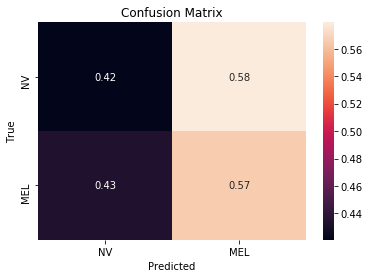

FileNotFoundError: [Errno 2] No such file or directory: '/home/mrb685/Confusions/ResNet50.png'

<Figure size 432x288 with 0 Axes>

In [14]:
# "VGG19", "ResNet50", "ResNet101V2", "ResNet152", "DenseNet121", "DenseNet201",
#                "efficientnet_b0", "efficientnet_b1", "efficientnet_b2", "efficientnet_b3", "efficientnet_b4",
#                "efficientnet_b5", "efficientnet_b6","efficientnet_b7"

model_names = ["ResNet50"]
datagen_params = [ (16, 256, 224)]
# model_names = ["efficientnet_b4"]
for i in range(len(model_names)): 
    name = model_names[i]
    print("---------------------------------")
    print(name)
    print("---------------------------------")
    
#     layers = ["25", "50", "75"]
#     for layer in layers:
    model_name = f"base_randcrop_binary_cw_{name}_auc" 
    model.load_weights(f"/home/mrb685/Saved Models/{model_name}.h5")


    BATCH_SIZE, IMG_SIZE, IMG_CROP_SIZE = datagen_params[i]
    IMG_SIZE = IMG_CROP_SIZE
    
    print(f"Datagen Param: {BATCH_SIZE}, {IMG_SIZE}, {IMG_CROP_SIZE}")
    
    datagen = ImageDataGenerator(rescale=1./255.,
                                 rotation_range=90,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 brightness_range=(0.8, 1.2),
                                validation_split=0.2)

    # datagen = ImageDataGenerator(rescale=1./255., validation_split=0.2)
    # val_datagen = ImageDataGenerator(rescale=1./255.)
    
    train_generator = datagen.flow_from_directory(
        target_size=(IMG_CROP_SIZE, IMG_CROP_SIZE),
        directory=train_path,
        batch_size=BATCH_SIZE, 
        shuffle = True,
        classes=CATEGORIES,
        subset="training",
        class_mode="binary")
    
    val_generator = datagen.flow_from_directory(
        batch_size=BATCH_SIZE,
        target_size=(IMG_CROP_SIZE, IMG_CROP_SIZE),
        directory = train_path,
        shuffle = True,
        subset="validation",
        classes=CATEGORIES,
        class_mode = "binary")

    

    #Confution Matrix and Classification Report
    Y_pred = model.predict(val_generator, verbose=1 )
    print(np.unique(Y_pred))
    y_pred = Y_pred < 0.2
    

    print('Confusion Matrix')
    cm = confusion_matrix(val_generator.classes, y_pred, normalize="true")

    ax= plt.subplot()

    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted');
    ax.set_ylabel('True'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(CATEGORIES); 
    ax.yaxis.set_ticklabels(CATEGORIES);
    plt.show()

    plt.savefig(f'/home/mrb685/Confusions/{name}.png')
    print('Classification Report')
    report = classification_report(val_generator.classes, y_pred, target_names=CATEGORIES,labels=range(2), output_dict=True)
    df = pd.DataFrame(report).transpose()

    print(classification_report(val_generator.classes, y_pred, target_names=CATEGORIES))

    fpr, tpr, thresholds = roc_curve(val_generator.classes, y_pred, pos_label=1)
    print(f"AUC : {auc(fpr, tpr)}")

In [ ]:
plt.figure(1)
plt.plot([0, 1], 'k--')
plt.plot(fpr, tpr, label=f'Keras (area = {auc}')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
Y_pred

In [ ]:
# "VGG19", "ResNet50", "ResNet101V2", "ResNet152", "DenseNet121", "DenseNet201",
#                "efficientnet_b0", "efficientnet_b1", "efficientnet_b2", "efficientnet_b3", "efficientnet_b4",
#                "efficientnet_b5", "efficientnet_b6","efficientnet_b7"

model_names = ["ResNet50", "ResNet152", "DenseNet121", "DenseNet201",
               "efficientnet_b0", "efficientnet_b1", "efficientnet_b2", "efficientnet_b3", "efficientnet_b4"]

# model_names = ["efficientnet_b4"]
for name in model_names: 
    print("---------------------------------")
    print(name)
    print("---------------------------------")
    
#     layers = ["25", "50", "75"]
#     for layer in layers:
    model_name = f"base_isic_randcrop_{name}" 
    model = load_model(f"/home/mrb685/Saved Models/{model_name}.h5")


    num_of_test_samples = 1651

    #Confution Matrix and Classification Report
    Y_pred = model.predict_generator(val_generator, num_of_test_samples // BATCH_SIZE +1, verbose=1)
    y_pred = np.argmax(Y_pred, axis=1)
    target_names = ["NV", "MEL", "BCC", "BKL", "AK", "SCC", "VASC", "DF"]

    print('Confusion Matrix')
    cm = confusion_matrix(val_generator.classes, y_pred, normalize='true')

    ax= plt.subplot()

    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted');
    ax.set_ylabel('True'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(target_names); 
    ax.yaxis.set_ticklabels(target_names);
    plt.show()

    plt.savefig(f'/home/mrb685/Confusions/{name}.png')
    print('Classification Report')
    report = classification_report(val_generator.classes, y_pred, target_names=target_names, output_dict=True)
    df = pd.DataFrame(report).transpose()

    print(classification_report(val_generator.classes, y_pred, target_names=target_names))

    fpr, tpr, thresholds = roc_curve(val_generator.classes, y_pred, pos_label=2)
    print(f"AUC : {auc(fpr, tpr)}")

In [ ]:
model_names = ["VGG19", "ResNet50", "ResNet101V2", "ResNet152", "DenseNet121", "DenseNet201",
               "efficientnet_b0", "efficientnet_b1", "efficientnet_b2", "efficientnet_b3", "efficientnet_b4",
               "efficientnet_b5", "efficientnet_b6","efficientnet_b7"]

for name in model_names:
    print("---------------------------------")
    print(name)
    print("---------------------------------")
    model_name = f"base_nocw_{name}" 
    model = load_model(f"/home/mrb685/Saved Models/{model_name}.h5")

    pred = model.evaluate(val_generator)

    print(pred)

In [ ]:
import os
from PIL import Image
size = 600, 600
count = 0
save_path = "/home/mrb685/Datasets/ISIC Resized/"
path = "/home/mrb685/Datasets/ISIC Only/"
for root, dirs, files in os.walk(save_path):
#     for file in files:
#         c_name = root.split("/")[-1]
#         if c_name not in ["VASC", "MEL", "AK", "BKL", "NV"]:
#             save_dir = os.path.join(save_path, c_name, file)
#             print(save_dir)
#             im = Image.open(root + "/" + file)
#             print(im.width, im.height)
#             im.thumbnail(size, Image.ANTIALIAS)
#             print(im.width, im.height)
#             im.save(save_dir, "JPEG")
    print(root)
    print(len(files))
    count = count + len(files)
    
print(count)